In [3]:
import os
import logging

import numpy as np
import matplotlib.pyplot as plt

import torch
# torch.cuda.set_device(0)
import torchvision.utils as vutils

from models.DualEncoderCelebA import DualEncoderCelebA
from models.funcs import FocalLoss
from visualize_tools import generate_coordinates
from FedServer import aggregate
from FedClientDVA import FedClient

# setups

In [4]:
d_z = 1  # d latent z
d_c = 1  # d latent c
# models shared
shared_list = {'backbone_z', 'backbone_c', 'encoder_c', 'encoder_z', 'embedding_z', 'embedding_x'}

optimizer_func = torch.optim.Adam  # optimizer
criterion = FocalLoss(gamma=5)  # criterion
# criterion = torch.nn.MSELoss()

# loss
xi = 0.5
lbd_dec = 1.
lbd_z = 1.
lbd_c = 1.
lbd_cc = 1.

# cuda
use_cuda = True
device = 'cuda' if torch.cuda.is_available() and use_cuda else 'cpu'

# training settings
batch = 256
lr = 0.001

n_rounds = 2
n_snapshot = 2

epoch_encoder_z = 2
epoch_encoder_c = 2
epoch_decoder = 2
n_resamples = 0

# federation settings
n_clients = 2
client_root = "clients/CelebA"
client_ids = [c_id for c_id in range(n_clients)]
path_to_data = "data/Images/CelebA.pt"
model_name = "fed_dva_celeba"

# logs

In [5]:
# create logger with 'spam_application'
logger = logging.getLogger('federation')
logger.setLevel(logging.INFO)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)


# load data

In [6]:
logger.info("load data")
tr_datasets = [torch.load(os.path.join(client_root, str(c_id), path_to_data)).get_fed_dataset(True)
               for c_id in client_ids]

ts_datasets = [torch.load(os.path.join(client_root, str(c_id), path_to_data)).get_fed_dataset(False)
               for c_id in client_ids]
tr_loaders = [torch.utils.data.DataLoader(tr_dataset, batch_size=batch, shuffle=True)
              for tr_dataset in tr_datasets]
n_tr_samples = [len(tr_dataset) for tr_dataset in tr_datasets]

ts_loaders = [torch.utils.data.DataLoader(ts_dataset, batch_size=1000, shuffle=True)
              for ts_dataset in ts_datasets]

2022-02-16 01:12:17,279 - federation - INFO - load data


# initialize models

In [7]:
logger.info("initialize clients")
global_model = FedClient(-1, shared_list.union({"decoder"}), optimizer_func, criterion
                           , client_root, DualEncoderCelebA(d_z, d_c)
                           , xi, lbd_dec, lbd_z, lbd_c, lbd_cc)
global_model.model = global_model.model.to(device)

client_models = [FedClient(int(c_id), shared_list.union({"decoder"}), optimizer_func, criterion
                           , client_root, DualEncoderCelebA(d_z, d_c)
                           , xi, lbd_dec, lbd_z, lbd_c, lbd_cc)
                 for c_id in client_ids]

for client_model in client_models:
    client_model.update_model(global_model)
    client_model.shared_list = shared_list

2022-02-16 01:12:24,952 - federation - INFO - initialize clients
2022-02-16 01:12:25,076 - federation.client:0 - INFO - client: 0 log 2022_02_16
2022-02-16 01:12:25,077 - federation.client:0 - INFO - Initialize client
2022-02-16 01:12:25,077 - federation.client:0 - INFO - model: DualEncoderCelebA
2022-02-16 01:12:25,078 - federation.client:0 - INFO - d_latent_z: 1, d_latent_c: 1
2022-02-16 01:12:25,140 - federation.client:1 - INFO - client: 1 log 2022_02_16
2022-02-16 01:12:25,140 - federation.client:1 - INFO - Initialize client
2022-02-16 01:12:25,141 - federation.client:1 - INFO - model: DualEncoderCelebA
2022-02-16 01:12:25,141 - federation.client:1 - INFO - d_latent_z: 1, d_latent_c: 1
2022-02-16 01:12:25,142 - federation.client:0 - INFO - update local models
2022-02-16 01:12:25,164 - federation.client:1 - INFO - update local models


# communication rounds

In [ ]:
logger.info("communication rounds")
for r in range(n_rounds):
    logger.info("round: " + str(r))

    for c_id, (tr_loader, client_model) in enumerate(zip(tr_loaders, client_models)):
        client_model.fit(device, r, tr_loader
                         , epoch_encoder_z, epoch_encoder_c, epoch_decoder
                         , lr, n_resamples)
        if r % n_snapshot == (n_snapshot - 1) or r == (n_rounds - 1):
            client_model.save_model(model_name + "_r{:d}".format(r))

    for para in global_model.model.parameters():
        para.data = torch.zeros_like(para.data)

    logger.info("aggregate models")
    global_model = aggregate(global_model, client_models, n_tr_samples)

    for client_model in client_models:
        client_model.update_model(global_model)

# check savings

In [8]:
logger.info("check savings")
for client_model in client_models:
    client_model.load_model(model_name + "_r{:d}".format(n_rounds - 1))

2022-02-16 01:12:29,933 - federation - INFO - check savings
2022-02-16 01:12:29,934 - federation.client:0 - INFO - load models: fed_dva_celeba_r1
2022-02-16 01:12:29,971 - federation.client:1 - INFO - load models: fed_dva_celeba_r1


# evaluate models

2022-02-16 01:12:41,313 - federation - INFO - evaluate models
2022-02-16 01:12:41,314 - federation.client:0 - INFO - evaluate models
2022-02-16 01:12:43,576 - federation.client:0 - INFO - Evaluate Decoder Loss: 508.35369873046875
2022-02-16 01:12:43,577 - federation.client:0 - INFO - Evaluate DKL z Loss: 0.8994624614715576
2022-02-16 01:12:43,578 - federation.client:0 - INFO - Evaluate DKL c Loss: 1.1024436950683594
2022-02-16 01:12:43,579 - federation.client:0 - INFO - Evaluate Constr c Loss : 3.4929425716400146


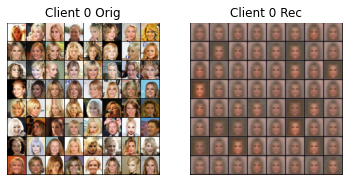

2022-02-16 01:12:43,715 - federation.client:1 - INFO - evaluate models
2022-02-16 01:12:45,641 - federation.client:1 - INFO - Evaluate Decoder Loss: 542.0208740234375
2022-02-16 01:12:45,642 - federation.client:1 - INFO - Evaluate DKL z Loss: 2.9104037284851074
2022-02-16 01:12:45,643 - federation.client:1 - INFO - Evaluate DKL c Loss: 0.3581516444683075
2022-02-16 01:12:45,643 - federation.client:1 - INFO - Evaluate Constr c Loss : 0.9659230709075928


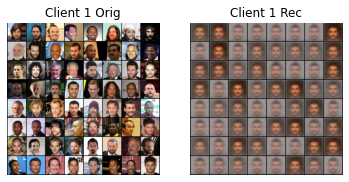

In [9]:
n_row = 8
n_col = 8

logger.info("evaluate models")
for c_id in client_ids:
    md = client_models[c_id]
    tl = ts_loaders[c_id]

    img, img_hat, z, c, mu_z, log_var_z, mu_c, log_var_c = md.evaluate(device, tl, 0)

    plt.figure()

    # display original images
    plt.subplot(1, 2, 1)
    plt.imshow(
        np.transpose(vutils.make_grid(img[:n_row * n_col].cpu(), nrow=n_col, padding=2, normalize=True), (1, 2, 0)))
    plt.axis("off")
    plt.title("Client {:d} Orig".format(c_id))

    # display rec images
    plt.subplot(1, 2, 2)
    plt.imshow(
        np.transpose(vutils.make_grid(img_hat[:n_row * n_col].detach().cpu(), nrow=n_col, padding=2, normalize=True),
                     (1, 2, 0)))
    plt.axis("off")
    plt.title("Client {:d} Rec".format(c_id))

    """
    plt.figure()
    # display latent distribution
    plt.scatter(mu_z.detach().cpu().squeeze(), mu_c.detach().cpu().squeeze())
    # plt.axis("off")
    plt.title("Client {:d} Distribution".format(c_id))
    """

    plt.show()

# generate samples

2022-02-16 01:12:58,530 - federation - INFO - generate samples
2022-02-16 01:12:58,531 - federation.client:0 - INFO - generate samples


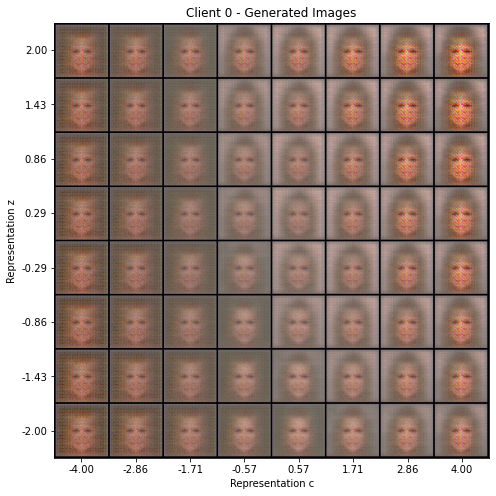

2022-02-16 01:12:58,851 - federation.client:1 - INFO - generate samples


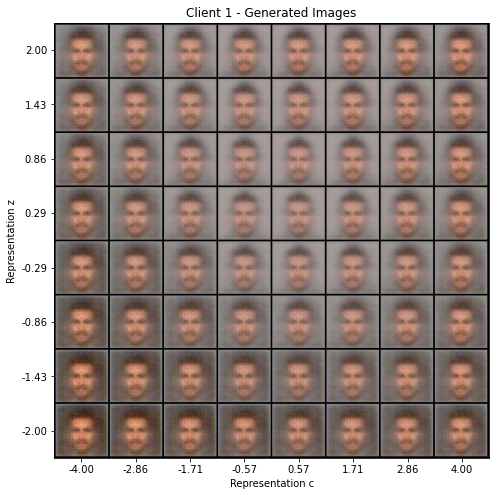

In [10]:
n_row = 8
n_col = 8

min_z, max_z = -2., 2.
min_c, max_c = -4., 4.

z, c, z_labels, c_labels = generate_coordinates(n_row, n_col, min_z, max_z, min_c, max_c)

logger.info("generate samples")
for c_id in client_ids:
    # generate images
    imgs = client_models[c_id].generate(device, z, c).detach().to("cpu")

    # display images
    plt.figure(figsize=(8,8))

    plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=n_col, padding=2, normalize=True),(1,2,0)))

    axes = plt.gca()
    x_min, x_max = axes.get_xlim()
    y_min, y_max = axes.get_ylim()

    x_steps = (x_max - x_min) / n_col
    y_steps = (y_max - y_min) / n_row

    plt.xticks(np.arange(x_min + 0.5 * x_steps, x_max, x_steps), c_labels, rotation=0)
    plt.yticks(np.arange(y_min + 0.5 * y_steps, y_max, y_steps), z_labels, rotation=0)

    # plt.axis("off")
    plt.title("Client {:d} - Generated Images".format(c_id))
    plt.ylabel('Representation z')
    plt.xlabel('Representation c')

    plt.show()